This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

## Load packages

In [1]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
import torch
from torch import sum
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as funcs
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage

path_prefix = ""

If running on Google Colab, you need to upload the file `autoencoder_starter.py`. To do so, you need to click on the folder icon on the left side of the page, which brings up a panel that would allow you to upload files. Note however uploading the file this way has a downside in that if your Python runtime times out or is otherwise restarted, the file will be erased and you will need to re-upload. 

If you would like to avoid this, you can create a directory named `CMPT_726Fall2021_A3` in your Google Drive and upload `autoencoder_starter.py` to that directory. Then execute the following block of code to mount your Google Drive. 

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.FashionMNIST(root='{}/./data'.format(path_prefix),  train=True,download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /./data/FashionMNIST/raw



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A4"

import sys
sys.path.insert(1, path_prefix)

Mounted at /content/gdrive


## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.


In [4]:
class VAE(nn.Module):

    def __init__(self,dim_latent_representation = 2):
        
        super(VAE,self).__init__()
        
        # Code added: To define KLD variable
        self.KLD = 0.0

        # Code added: To implement Decoder Class
        class Encoder(nn.Module):
            def __init__(self, output_size = 2):
                super(Encoder, self).__init__()
                self.encoder_layer_1 = nn.Linear(28*28*1,1024)
                self.encoder_mu = nn.Linear(1024,output_size)
                self.encoder_log_var = nn.Linear(1024,output_size)

            def forward(self, x):
                x = torch.tanh(self.encoder_layer_1(x))
                self.mu = self.encoder_mu(x)
                self.log_var = self.encoder_log_var(x)
                return self.mu, self.log_var

        # Code added: To implement Decoder Class
        class Decoder(nn.Module):
            def __init__(self, input_size = 2):
                super(Decoder, self).__init__()
                self.decoder_layer_1 = nn.Linear(input_size,1024)
                self.decoder_layer_2 = nn.Linear(1024,28*28*1)
                
            def forward(self, z):
                z = funcs.relu(self.decoder_layer_1(z))
                z_sig = torch.sigmoid(self.decoder_layer_2(z))
                return z_sig

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Code added : To implement reparameterise for the VAE model
    def reparameterise(self, mu, log_var):
        if self.training:
          std = torch.exp(log_var * (1/2))
          eps = torch.randn_like(std)
          return eps.mul(std).add_(mu)
        else:
          return mu
            
    # Code added: To implement forward function
    def forward(self,x):
        mu, log_var = self.encoder(x)
        z = self.reparameterise(mu, log_var)
        x = self.decoder(z)
        self.KLD = -(1/2) * sum(1 - mu**2 +log_var - log_var.exp())
        return x, mu, log_var

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

In [6]:
from VAE_starter import VAE_Trainer
from VAE_starter import Plot_Kernel

# Code added to tune best hyper-parameters
LEARNING_RATE = 0.0001
EPOCH_NUMBER= 20 # the number of epochs and learning rate can be tuned.

autoencoder = VAE(dim_latent_representation = 30)
trainer = VAE_Trainer(autoencoder_model = autoencoder,learning_rate = LEARNING_RATE,path_prefix = path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1875/1875 [00:56<00:00, 33.35it/s]

====> Epoch: 1 Average loss: 2.6602



100%|██████████| 313/313 [00:03<00:00, 96.68it/s]

====> Val set loss (reconstruction error) : 1.4203



100%|██████████| 1875/1875 [00:56<00:00, 33.05it/s]

====> Epoch: 2 Average loss: 1.2087



100%|██████████| 313/313 [00:03<00:00, 97.52it/s]

====> Val set loss (reconstruction error) : 1.1658



100%|██████████| 1875/1875 [00:56<00:00, 33.08it/s]

====> Epoch: 3 Average loss: 1.0769



100%|██████████| 313/313 [00:03<00:00, 96.44it/s] 

====> Val set loss (reconstruction error) : 1.0818



100%|██████████| 1875/1875 [00:56<00:00, 33.35it/s]

====> Epoch: 4 Average loss: 1.0316



100%|██████████| 313/313 [00:03<00:00, 97.57it/s] 

====> Val set loss (reconstruction error) : 1.0399



100%|██████████| 1875/1875 [00:55<00:00, 33.52it/s]

====> Epoch: 5 Average loss: 1.0205



100%|██████████| 313/313 [00:03<00:00, 98.38it/s] 

====> Val set loss (reconstruction error) : 1.0200



100%|██████████| 1875/1875 [00:56<00:00, 33.15it/s]

====> Epoch: 6 Average loss: 1.0126



100%|██████████| 313/313 [00:03<00:00, 94.66it/s]

====> Val set loss (reconstruction error) : 1.0157



100%|██████████| 1875/1875 [00:56<00:00, 33.02it/s]

====> Epoch: 7 Average loss: 1.0078



100%|██████████| 313/313 [00:03<00:00, 98.41it/s]

====> Val set loss (reconstruction error) : 1.0047



100%|██████████| 1875/1875 [00:56<00:00, 33.40it/s]

====> Epoch: 8 Average loss: 0.9988



100%|██████████| 313/313 [00:03<00:00, 98.71it/s]

====> Val set loss (reconstruction error) : 0.9993



100%|██████████| 1875/1875 [00:57<00:00, 32.88it/s]

====> Epoch: 9 Average loss: 1.0002



100%|██████████| 313/313 [00:03<00:00, 86.13it/s]

====> Val set loss (reconstruction error) : 1.0032



100%|██████████| 1875/1875 [01:01<00:00, 30.56it/s]

====> Epoch: 10 Average loss: 1.0023



100%|██████████| 313/313 [00:03<00:00, 91.98it/s]

====> Val set loss (reconstruction error) : 1.0024



100%|██████████| 1875/1875 [01:01<00:00, 30.51it/s]

====> Epoch: 11 Average loss: 1.0008



100%|██████████| 313/313 [00:03<00:00, 91.31it/s] 

====> Val set loss (reconstruction error) : 1.0055



100%|██████████| 1875/1875 [01:01<00:00, 30.33it/s]

====> Epoch: 12 Average loss: 1.0014



100%|██████████| 313/313 [00:03<00:00, 92.08it/s] 

====> Val set loss (reconstruction error) : 1.0133



100%|██████████| 1875/1875 [01:00<00:00, 30.75it/s]

====> Epoch: 13 Average loss: 1.0000



100%|██████████| 313/313 [00:03<00:00, 92.92it/s]

====> Val set loss (reconstruction error) : 1.0062



100%|██████████| 1875/1875 [01:02<00:00, 29.99it/s]

====> Epoch: 14 Average loss: 0.9970



100%|██████████| 313/313 [00:03<00:00, 89.97it/s]

====> Val set loss (reconstruction error) : 1.0065



100%|██████████| 1875/1875 [01:00<00:00, 30.84it/s]

====> Epoch: 15 Average loss: 0.9969



100%|██████████| 313/313 [00:03<00:00, 93.15it/s]

====> Val set loss (reconstruction error) : 1.0034



100%|██████████| 1875/1875 [01:02<00:00, 30.08it/s]

====> Epoch: 16 Average loss: 0.9954



100%|██████████| 313/313 [00:03<00:00, 91.77it/s]

====> Val set loss (reconstruction error) : 0.9972



100%|██████████| 1875/1875 [01:01<00:00, 30.69it/s]

====> Epoch: 17 Average loss: 0.9934



100%|██████████| 313/313 [00:03<00:00, 92.83it/s]

====> Val set loss (reconstruction error) : 0.9946



100%|██████████| 1875/1875 [01:01<00:00, 30.30it/s]

====> Epoch: 18 Average loss: 0.9919



100%|██████████| 313/313 [00:03<00:00, 90.84it/s]

====> Val set loss (reconstruction error) : 0.9955



100%|██████████| 1875/1875 [01:04<00:00, 29.15it/s]

====> Epoch: 19 Average loss: 0.9918



100%|██████████| 313/313 [00:03<00:00, 93.08it/s]

====> Val set loss (reconstruction error) : 0.9922



100%|██████████| 1875/1875 [01:01<00:00, 30.46it/s]

====> Epoch: 20 Average loss: 0.9920



100%|██████████| 313/313 [00:03<00:00, 93.94it/s]

====> Val set loss (reconstruction error) : 0.9930


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If in the above cell, you find that the download of the dataset is unsuccessful because the server is down, you can also download the data from Canvas and put the data in the same directory of this notebook and `autoencoder_starter.py`. If you are running this notebook on Google Colab, you can create a directory called `CMPT_726Fall2021_A3` in your Google Drive and put the data directory you downloaded from Canvas inside. Then if you haven't mounted your Google Drive earlier using the block of code above, mount Google Drive by executing the following block of code.

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A4"

Mounted at /content/gdrive


## Visualizing 2D Bottleneck Feature Representations

1.   List item
2.   List item



We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 3.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.938362
[t-SNE] KL divergence after 300 iterations: 2.279088


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


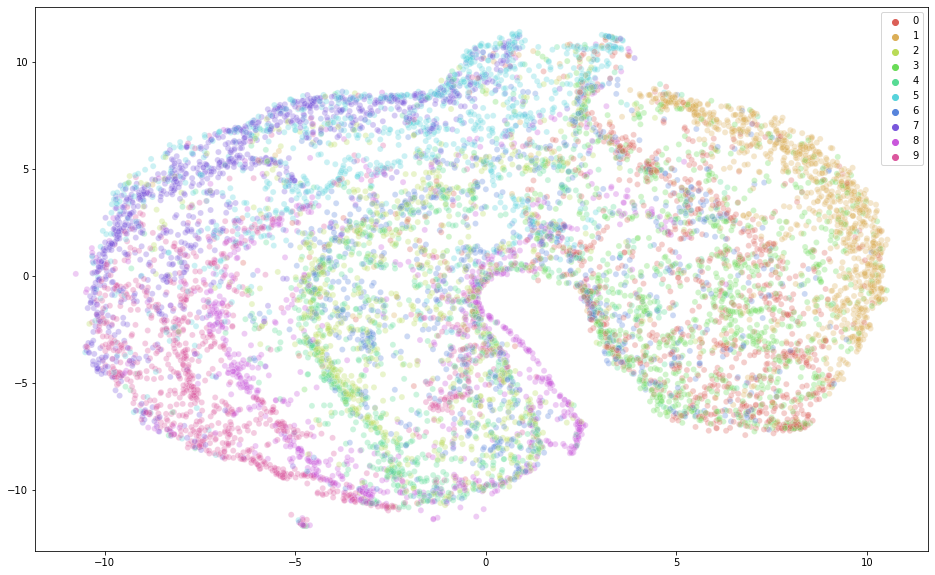

In [9]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:
        x = x.view(-1, 784)
        mu, log_var = model.encoder(x.to(trainer.device))
        z_ = model.reparameterise(mu, log_var)
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)
    
from VAE_starter import scatter_plot
scatter_plot(latent_representations=z,labels=label)

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


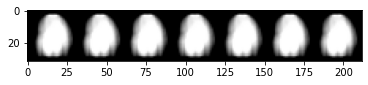

In [10]:
with torch.no_grad():
    samples = torch.randn(7, 30).to(trainer.device)
    samples = trainer.model.decoder(samples).cpu()

images = samples

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Original images


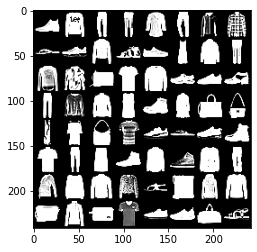

In [11]:
images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

from autoencoder_starter import display_images_in_a_row
print("Original images")
display_images_in_a_row(images.cpu())

reconstructed:64:::<class 'torch.Tensor'>
Reconstructed images


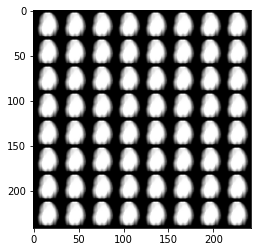

In [12]:
with torch.no_grad():
    images = images.view(-1,784)
    images = images.to(trainer.device)
    # reconstructed = trainer.model(images).cpu()
    reconstructed, mu, log_var = trainer.model(images)
    print(f"reconstructed:{len(reconstructed)}:::{type(reconstructed)}")
print("Reconstructed images")
display_images_in_a_row(reconstructed)